Make a big pandas dataframe to hold all the metric values we're interested in, so then we can pass it around and plot it up any way we like

I guess depth in each filter for each DDF?



In [1]:
import glob
import pandas as pd
import sqlite3
import numpy as np
import matplotlib.pylab as plt
import os
%matplotlib inline

In [2]:
# I just coppied them over from hyak and sym linked them to this directory for ease of use
glance_15_dirs = glob.glob('sims_featureScheduler_runs1.5/maf/*_glance')
#sci_15_dirs = glob.glob('sims_featureScheduler_runs1.5/maf/*_sci')
glance_16_dirs = glob.glob('sims_featureScheduler_runs1.6/maf/*_glance')
#sci_16_dirs = glob.glob('sims_featureScheduler_runs1.6/maf/*_sci')
glance_14_dirs = glob.glob('sims_featureScheduler_runs1.4/maf_all/*_glance')
#sci_14_dirs = glob.glob('sims_featureScheduler_runs1.4/maf_all/*_sci')

# re-run science directories
sci_14_dirs = glob.glob('fbs_1.4/*/')
sci_14_dirs = [di+'science/' for di in sci_14_dirs]

sci_15_dirs = glob.glob('fbs_1.5/*/')
sci_15_dirs = [di+'science/' for di in sci_15_dirs]

sci_16_dirs = glob.glob('fbs_1.6/*/')
sci_16_dirs = [di+'science/' for di in sci_16_dirs]


# XXX--note, glob does not return things in any particular order!!!
glance_14_dirs.sort()
sci_14_dirs.sort()
glance_15_dirs.sort()
sci_15_dirs.sort()
glance_16_dirs.sort()
sci_16_dirs.sort()





In [3]:
# Need to toss a few 1.4 runs that didn't end up in sci
rn_glance = [n1.replace('sims_featureScheduler_runs1.4/maf_all/','').replace('_glance', '') for n1 in glance_14_dirs]
rn_sci = [n1.replace('fbs_1.4/', '').replace('/science/', '') for n1 in sci_14_dirs]

inter, indx1, indx2 = np.intersect1d(rn_glance, rn_sci, return_indices=True)

glance_14_dirs = [glance_14_dirs[i] for i in indx1]
sci_14_dirs = [sci_14_dirs[i] for i in indx2]


In [4]:
# Let's make sure everything matches up
for n1,n2 in zip(glance_14_dirs, sci_14_dirs):
    assert(n1.replace('sims_featureScheduler_runs1.4/maf_all/','').replace('_glance', '') == n2.replace('fbs_1.4/', '').replace('/science/', ''))

for n1,n2 in zip(glance_15_dirs, sci_15_dirs):
    assert(n1.replace('sims_featureScheduler_runs1.5/maf/','').replace('_glance', '') == n2.replace('fbs_1.5/', '').replace('/science/', ''))
for n1,n2 in zip(glance_16_dirs, sci_16_dirs):
    assert(n1.replace('sims_featureScheduler_runs1.6/maf/','').replace('_glance', '') == n2.replace('fbs_1.6/', '').replace('/science/', ''))


In [5]:
runNames = [name[38:-13] for name in glance_14_dirs] + [name[34:-13] for name in glance_15_dirs] + [name[34:-13] for name in glance_16_dirs] 
versions = [1.4]*len(glance_14_dirs) +[1.5]*len(glance_15_dirs) + [1.6]*len(glance_16_dirs)

In [6]:
# Set up the dataframe
df = pd.DataFrame(np.array([runNames, versions]).T, columns=['runName', 'version'])

In [7]:
# List of tupes with (metricName, summaryName) that we want to pull from glance dirs
mnamesname =[('parallax', 'best18k'),
            ('properMotion', 'best18k'),
            ('fO', 'fONv MedianNvis'),
            ('fO', 'fOArea')]

In [8]:
for names in mnamesname:
    column_vals = []
    sql = 'select summaryValue from summarystats where metricId = (select metricId from metrics where metricName = "%s") and summaryName= "%s";' % (names[0], names[1])
    for directory in glance_14_dirs+glance_15_dirs+glance_16_dirs:
        conn = sqlite3.connect(directory+'/resultsDb_sqlite.db')
        result = pd.read_sql(sql, conn).values.ravel()
        if np.size(result) > 1:
            ValueError
        else:
            column_vals.append(np.max(result))
        conn.close()
    df[names[0]+'_'+names[1]] = column_vals

In [9]:
# Add the median coadded depths in each filter
for filtername in 'ugrizy':
    column_vals = []
    sql = 'select summaryValue from summarystats where metricId = (select metricId from metrics where metricName = "CoaddM5" and metricMetadata=" %s") and summaryName= "Median";' % (filtername)
    for directory in glance_14_dirs+glance_15_dirs+glance_16_dirs:
        conn = sqlite3.connect(directory+'/resultsDb_sqlite.db')
        result = pd.read_sql(sql, conn).values.ravel()
        if np.size(result) > 1:
            ValueError
        else:
            column_vals.append(np.max(result))
        conn.close()
    df['median_coadd_%s' % filtername] = column_vals


In [15]:
# List of tupes with (metricName, summaryName) that we want to pull from science dirs
mnamesname =[('SNIa_PrePeak', 'Mean'),
            ('Fast Microlensing', 'Mean'),
            ('Slow Microlensing', 'Mean'),
            ('KN_PrePeak', 'Mean'),
            ('GalaxyCountsMetric_extended', 'N Galaxies (all)'),
            ('TDEsPopMetric__some_color', 'Mean'),
            ('WeakLensingNvisits fiveSigmaDepth, visitExposureTime', 'Median')]

In [16]:
for names in mnamesname:
    column_vals = []
    sql = 'select summaryValue from summarystats where metricId = (select metricId from metrics where metricName = "%s") and summaryName= "%s";' % (names[0], names[1])
    for directory in sci_14_dirs+sci_15_dirs+sci_16_dirs:
        conn = sqlite3.connect(directory+'/resultsDb_sqlite.db')
        result = pd.read_sql(sql, conn).values.ravel()
        if np.size(result) > 1:
            ValueError
        else:
            column_vals.append(np.max(result))
        conn.close()
    df[names[0]+'_'+names[1]] = column_vals

In [17]:
# things that need some metadata
mnamesname =[('Nstars_no_crowding', 'Total N Stars, no crowding')]

for names in mnamesname:
    column_vals = []
    sql = 'select summaryValue from summarystats where metricId = (select metricId from metrics where metricName = "%s" and metricMetadata=" i") and summaryName= "%s";' % (names[0], names[1])
    for directory in sci_14_dirs+sci_15_dirs+sci_16_dirs:
        conn = sqlite3.connect(directory+'/resultsDb_sqlite.db')
        result = pd.read_sql(sql, conn).values.ravel()
        if np.size(result) > 1:
            ValueError
        else:
            column_vals.append(np.max(result))
        conn.close()
    df[names[0]+'_'+names[1]] = column_vals

    
mnamesname =[('ExgalM5_with_cuts fiveSigmaDepth, filter', '3x2ptFoM')]

for names in mnamesname:
    column_vals = []
    sql = 'select summaryValue from summarystats where metricId = (select metricId from metrics where metricName = "%s" and metricMetadata="i band non-DD year 10") and summaryName= "%s";' % (names[0], names[1])
    for directory in sci_14_dirs+sci_15_dirs+sci_16_dirs:
        conn = sqlite3.connect(directory+'/resultsDb_sqlite.db')
        result = pd.read_sql(sql, conn).values.ravel()
        if np.size(result) > 1:
            ValueError
        else:
            column_vals.append(np.max(result))
        conn.close()
    df[names[0]+'_'+names[1]] = column_vals


In [18]:
# Pull the DDF depths from everywhere. 
filters = 'ugrizy'
ddf_names = ['DD:ELAISS1', 'DD:XMM-LSS', 'DD:ECDFS', 'DD:COSMOS', 'DD:EDFS', 'DD:EDFSa', 'DD:EDFSb']

for filtername in filters:
    for ddf_name in ddf_names:
        column_vals = []
        sql = 'select summaryValue from summarystats where summaryName="Median depth %s, %s"' % (ddf_name, filtername)
        for directory in sci_14_dirs+sci_15_dirs+sci_16_dirs:
            conn = sqlite3.connect(directory+'/resultsDb_sqlite.db')
            result = pd.read_sql(sql, conn).values.ravel()
            if np.size(result) > 1:
                ValueError
            else:
                column_vals.append(np.max(result))
            conn.close()
        df[ddf_name+','+filtername] = column_vals

In [19]:
# From https://epyc.astro.washington.edu/~lynnej/opsim_downloads/
ss_14 = pd.read_csv('discovery_1.4.csv').sort_values('Unnamed: 0')
ss_15 = pd.read_csv('discovery_1.5.csv').sort_values('Unnamed: 0')
ss_16 = pd.read_csv('discovery_1.6.csv').sort_values('Unnamed: 0')



In [20]:
# len(glance_16_dirs), len(ss_16)
print(len(glance_15_dirs), len(ss_15))
print(len(glance_14_dirs), len(ss_14))
print(len(glance_16_dirs), len(ss_16))


86 86
118 116
30 30


In [21]:
# Let's add the new columns
to_add_columns = list(ss_14.columns)[1:]
blank = np.zeros(len(df)) +np.nan

for colname in to_add_columns:
    df[colname] = blank

In [22]:
# Loop through things and populate df
runnames = df['runName'].values
for i in ss_14.index:
    rn = ss_14['Unnamed: 0'][i][0:-6]
    indx = np.where(rn == runnames)[0]
    if np.size(indx) == 1:
        for col in to_add_columns:
            df[col][indx] = ss_14[col][i]+0
            
# Loop through things and populate df
runnames = df['runName'].values
for i in ss_15.index:
    rn = ss_15['Unnamed: 0'][i][0:-6]
    indx = np.where(rn == runnames)[0]
    if np.size(indx) == 1:
        for col in to_add_columns:
            df[col][indx] = ss_15[col][i]+0
            
            
# Loop through things and populate df
runnames = df['runName'].values
for i in ss_16.index:
    rn = ss_16['Unnamed: 0'][i][0:-6]
    indx = np.where(rn == runnames)[0]
    if np.size(indx) == 1:
        for col in to_add_columns:
            df[col][indx] = ss_16[col][i]+0

/Users/yoachim/lsst/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/yoachim/lsst/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/yoachim/lsst/python/miniconda3-4.5.12/envs/lsst-scipipe-1172c30/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexin

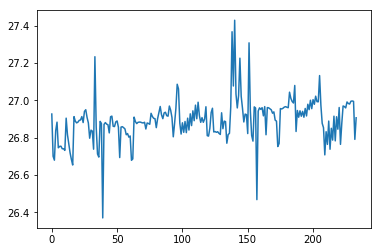

In [23]:
plt.plot(df['median_coadd_g'])

In [24]:
df.columns

Index(['runName', 'version', 'parallax_best18k', 'properMotion_best18k',
       'fO_fONv MedianNvis', 'fO_fOArea', 'median_coadd_u', 'median_coadd_g',
       'median_coadd_r', 'median_coadd_i', 'median_coadd_z', 'median_coadd_y',
       'SNIa_PrePeak_Mean', 'Fast Microlensing_Mean', 'Slow Microlensing_Mean',
       'KN_PrePeak_Mean', 'GalaxyCountsMetric_extended_N Galaxies (all)',
       'TDEsPopMetric__some_color_Mean',
       'WeakLensingNvisits fiveSigmaDepth, visitExposureTime_Median',
       'Nstars_no_crowding_Total N Stars, no crowding',
       'ExgalM5_with_cuts fiveSigmaDepth, filter_3x2ptFoM', 'DD:ELAISS1,u',
       'DD:XMM-LSS,u', 'DD:ECDFS,u', 'DD:COSMOS,u', 'DD:EDFS,u', 'DD:EDFSa,u',
       'DD:EDFSb,u', 'DD:ELAISS1,g', 'DD:XMM-LSS,g', 'DD:ECDFS,g',
       'DD:COSMOS,g', 'DD:EDFS,g', 'DD:EDFSa,g', 'DD:EDFSb,g', 'DD:ELAISS1,r',
       'DD:XMM-LSS,r', 'DD:ECDFS,r', 'DD:COSMOS,r', 'DD:EDFS,r', 'DD:EDFSa,r',
       'DD:EDFSb,r', 'DD:ELAISS1,i', 'DD:XMM-LSS,i', 'DD:ECDFS,i',
  

In [25]:
# pickle would be much smaller, but I guess can zip after if we want to
df.to_hdf('combined_maf_dataframe.hdf', 'maf')
# restore with:
# df = pd.read_hdf('combined_maf_dataframe.hdf', 'maf')